# CaData dataset

Comparison of different inducing point GP-regression methods.

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading the data

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/cadata(20640, 8).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'cadata'
file_name = data_name

x_tr = x_tr.toarray().T
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]


x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

of objects: 16512
of features 8
cadata


## SVM
We train an SVM with RBF kernel for reference.

In [6]:
svm = SVR(C=1e2)
svm.fit(x_tr.T, y_tr[:, 0])
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.77934627149937497

# K-means cluster centers as inducing inputs

We use K-means cluster centers as inducing point positions and don't optimize wrt them.

In [168]:
ind_num = 200
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [169]:
cov_params = np.array([3.3, 10., 1.3])
# cov_params = np.array([1., 1., .5])

# SVI-L-BFGS-B

L-BFGS-B optimization method applied to the svi objective (see the text).

In [196]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
lbfgs_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [197]:
opts = {'maxiter': 500, 'mydisp': True, 'print_freq': 10}
lbfgs_svi_res = lbfgs_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Hyper-parameters at iteration 0 : [  3.3         10.           1.3         -0.79926608   1.20951848]
Hyper-parameters at iteration 10 : [  1.79266562  10.53158048   0.60365767  -0.80200436   1.14706952]
Hyper-parameters at iteration 20 : [ 2.14541459  9.5956357   0.58862637 -0.81301434  0.79684212]
Hyper-parameters at iteration 30 : [ 2.43585432  9.2700395   0.58839879 -0.87979316  0.5510623 ]
Hyper-parameters at iteration 40 : [ 2.58291274  9.53417149  0.57255743 -0.85679342  0.377398  ]
Hyper-parameters at iteration 50 : [ 2.6754298   9.298734    0.57565712 -0.87082998  0.34990492]
Hyper-parameters at iteration 60 : [ 2.67332489  9.1951248   0.57321349 -0.87035551  0.39026741]
Hyper-parameters at iteration 70 : [ 2.58152138  8.72297412  0.57124855 -0.82874301  0.504511  ]
Hyper-parameters at iteration 80 : [ 2.4233067   8.21987671  0.56877407 -0.84030152  0.5798225 ]
Hyper-parameters at iteration 90 : [ 2.07092146  7.27313747  0.56474263 -0.77419719  0.80060331]
Hyper-parameters at i

In [198]:
metric = lambda w: lbfgs_svi_gp.get_prediction_quality(w, x_test, y_test)
lbfgs_svi_x_lst, lbfgs_svi_y_lst = lbfgs_svi_res.plot_performance(metric, 'i', freq=5)

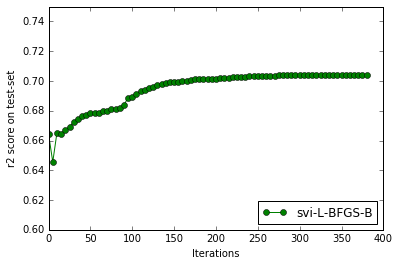

In [199]:
plt.plot(lbfgs_svi_x_lst, lbfgs_svi_y_lst, '-go', label='svi-L-BFGS-B')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [200]:
lbfgs_svi_y_lst[-1]

0.70398730197137194

In [202]:
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_x.npy', lbfgs_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_lbfgs_svi_y.npy', lbfgs_svi_y_lst)

## VI
L-BFGS-B optimization method applied to the vi objective (see the text).

In [203]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [204]:
opts = {'maxiter': 50, 'mydisp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Hyper-parameters at iteration 0 : [  3.3  10.    1.3]
Hyper-parameters at iteration 1 : [  1.68915073  16.80204679   0.66839041]
Hyper-parameters at iteration 2 : [  1.76334526  16.58459074   0.60226314]
Hyper-parameters at iteration 3 : [  2.69925851  13.01358884   0.59013477]
Hyper-parameters at iteration 4 : [ 3.33453391  8.95131144  0.55776185]
Hyper-parameters at iteration 5 : [ 3.65215633  6.88764702  0.55353824]
Hyper-parameters at iteration 6 : [ 3.65298157  6.77379632  0.5458797 ]
Hyper-parameters at iteration 7 : [ 3.63432252  6.85527443  0.54397214]
Hyper-parameters at iteration 8 : [ 3.62780914  6.88934519  0.54742245]
Hyper-parameters at iteration 9 : [ 2.92026374  6.56485322  0.54676058]
Hyper-parameters at iteration 10 : [ 2.38733958  6.18616818  0.54757368]
Hyper-parameters at iteration 11 : [ 2.0493391   5.72609876  0.54967852]
Hyper-parameters at iteration 12 : [ 2.13657859  5.57506718  0.55047961]
Hyper-parameters at iteration 13 : [ 1.98817209  5.52451289  0.5505076

In [205]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 'i', freq=1)

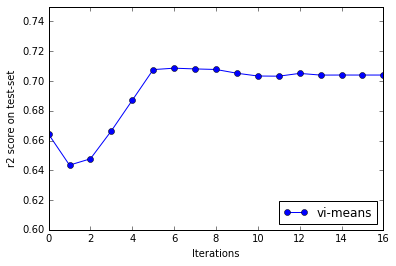

In [206]:
plt.plot(vi_x_lst, vi_y_lst, '-bo', label='vi-means')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [207]:
vi_y_lst[-1]

0.70400491445099844

In [208]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_x.npy', vi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_y.npy', vi_y_lst)

## Stochastic SVI
Stochastic (incremental) optimization methods applied to the svi objective (see the text).
### AdaDelta-Cholesky
Adadelta method from climin library.

In [223]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='AdaDelta')

In [224]:
opts = {'mydisp': True, 'print_freq': 10, 'step_rate': 1.,
                'maxiter': 500, 'batch_size':500}
ad_svi_res = ad_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Iteration  9 :
	Gradient norm 0.100607490045
Iteration  19 :
	Gradient norm 0.0516215822444
Iteration  29 :
	Gradient norm 0.0731385040711
Iteration  39 :
	Gradient norm 0.190997852929
Iteration  49 :
	Gradient norm 0.0648368865618
Iteration  59 :
	Gradient norm 0.354841856272
Iteration  69 :
	Gradient norm 0.132902874259
Iteration  79 :
	Gradient norm 0.229761076526
Iteration  89 :
	Gradient norm 0.117777572901
Iteration  99 :
	Gradient norm 0.173237206129
Iteration  109 :
	Gradient norm 0.0769942891782
Iteration  119 :
	Gradient norm 0.495170604699
Iteration  129 :
	Gradient norm 0.09500059811
Iteration  139 :
	Gradient norm 0.157714882428
Iteration  149 :
	Gradient norm 0.144476436895
Iteration  159 :
	Gradient norm 0.388445909299
Iteration  169 :
	Gradient norm 0.226948573523
Iteration  179 :
	Gradient norm 0.383870099292
Iteration  189 :
	Gradient norm 0.22837752123
Iteration  199 :
	Gradient norm 0.175128150632
Iteration  209 :
	Gradient norm 0.0675355735181
Iteration  219 :
	Gra

In [225]:
metric = lambda w: ad_svi_gp.get_prediction_quality(w, x_test, y_test)
ad_svi_x_lst, ad_svi_y_lst = ad_svi_res.plot_performance(metric, 'i', freq=5)

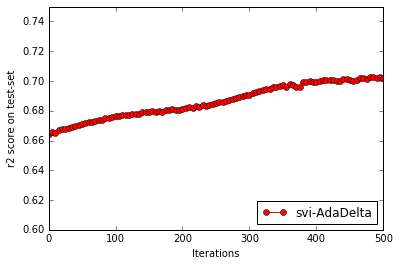

In [226]:
plt.plot(ad_svi_x_lst, ad_svi_y_lst, '-ro', label='svi-AdaDelta')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [227]:
ad_svi_y_lst[-1]

0.70205701424333622

In [228]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_x.npy', ad_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_y.npy', ad_svi_y_lst)

###SG-cholesky
Stochastic gradient descent.

In [305]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sg_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SG')

In [306]:
opts = {'maxiter':1000, 'batch_size': 200 , 'print_freq': 50, 'step0': 3e-1, 'gamma': .01}
sg_svi_res = sg_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.3
	Parameters [  1.96362013  10.37004586]
Epoch  50 :
	Step: 0.288490525427
	Parameters [ 2.08793606  9.91711121]
Epoch  100 :
	Step: 0.286497775806
	Parameters [ 2.4606587   9.68093673]
Epoch  150 :
	Step: 0.28533847915
	Parameters [ 2.54738651  9.54465329]
Epoch  200 :
	Step: 0.284518791113
	Parameters [ 2.69397953  9.24251752]
Epoch  250 :
	Step: 0.283884613604
	Parameters [ 2.67913964  8.96682298]
Epoch  300 :
	Step: 0.283367502303
	Parameters [ 2.66653747  8.56237204]
Epoch  350 :
	Step: 0.282931025874
	Parameters [ 2.52265549  8.07179827]
Epoch  400 :
	Step: 0.282553476265
	Parameters [ 2.32880908  7.43048659]
Epoch  450 :
	Step: 0.282220872117
	Parameters [ 2.0779494   6.64398433]
Epoch  500 :
	Step: 0.281923679341
	Parameters [ 1.96299151  6.08032356]
Epoch  550 :
	Step: 0.281655105384
	Parameters [ 2.11785719  5.88065237]
Epoch  600 :
	Step: 0.281410139988
	Parameters [ 2.10010913  5.90532002]
Epoch  650 :
	Step: 0.281184981816
	Parameters [ 2.13887091  5.8

In [307]:
metric = lambda w: sg_svi_gp.get_prediction_quality(w, x_test, y_test)
sg_svi_x_lst, sg_svi_y_lst = sg_svi_res.plot_performance(metric, 'i', freq=1)

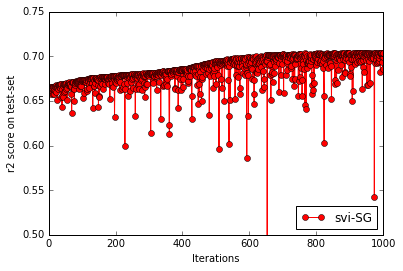

In [308]:
plt.plot(sg_svi_x_lst, sg_svi_y_lst, '-ro', label='svi-SG')
plt.ylim([.5, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [309]:
sg_svi_y_lst[-1]

0.70312428856048859

In [310]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sg_svi_x.npy', sg_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sg_svi_y.npy', sg_svi_y_lst)

### SG-Natural
Stochastic gradient descent with natural gradients with respect to the variational parameters.

In [333]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural')

In [334]:
opts = {'maxiter':3000, 'batch_size': 200 , 'print_freq': 50, 'step0': 3e-1, 'gamma': 0.05}
sng_svi_res = sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.3
	Parameters [  1.97621118  10.36828448]
Epoch  50 :
	Step: 0.246702047828
	Parameters [ 1.62730541  9.82532474]
Epoch  100 :
	Step: 0.238298470417
	Parameters [ 1.61737019  9.35756693]
Epoch  150 :
	Step: 0.233516026319
	Parameters [ 1.51676602  8.98566409]
Epoch  200 :
	Step: 0.230181149703
	Parameters [ 1.4932229   8.66045673]
Epoch  250 :
	Step: 0.227627251385
	Parameters [ 1.45090081  8.37375269]
Epoch  300 :
	Step: 0.225561613207
	Parameters [ 1.49373335  8.1223852 ]
Epoch  350 :
	Step: 0.223829772092
	Parameters [ 1.37017381  7.88479909]
Epoch  400 :
	Step: 0.222340334732
	Parameters [ 1.33983924  7.68686317]
Epoch  450 :
	Step: 0.221034786812
	Parameters [ 1.34386279  7.43278904]
Epoch  500 :
	Step: 0.219873431566
	Parameters [ 1.26373326  7.25274619]
Epoch  550 :
	Step: 0.218828115461
	Parameters [ 1.27878393  7.10761651]
Epoch  600 :
	Step: 0.217878156608
	Parameters [ 1.24134287  6.86680515]
Epoch  650 :
	Step: 0.217007921289
	Parameters [ 1.26182225  6.

In [335]:
metric = lambda w: sng_svi_gp.get_prediction_quality(w, x_test, y_test)
sng_svi_x_lst, sng_svi_y_lst = sng_svi_res.plot_performance(metric, 'i', freq=1)

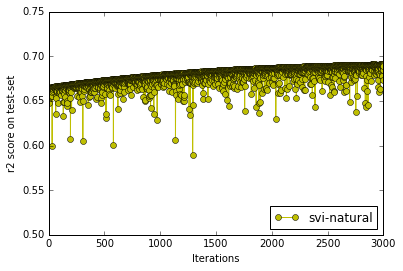

In [336]:
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([.5, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [337]:
sng_svi_y_lst[-1]

0.68920857684242076

In [338]:
np.max(sng_svi_y_lst)

0.69113063653679596

In [339]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sng_svi_x.npy', sng_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sng_svi_y.npy', sng_svi_y_lst)